In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [84]:
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 64    #批处理尺寸(batch_size)
LR = 0.001        #学习率

In [85]:
# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    
    transforms.RandomHorizontalFlip(0.5),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.RandomVerticalFlip(0.5),  # 竖直翻转
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((128)),
    transforms.RandomCrop(128, padding=4),
#     transforms.ColorJitter(brightness=0.5),
#     transforms.ColorJitter(contrast=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), # 调整图像大小
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [86]:
train_dir = r'D:/Python_first/learn/pytorch/data/fish_/train/'
train_datasets = datasets.ImageFolder(train_dir, transform=transform_train)
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dir = r'D:/Python_first/learn/pytorch/data/fish_/val/'
test_datasets = datasets.ImageFolder(test_dir, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([10,  0,  0,  0,  4,  2,  1,  0,  9,  4,  0,  1,  4,  0,  4,  8,  0,  3,
        11,  9, 13,  1,  4,  9,  0,  0,  2,  2,  0,  0,  2,  0,  4,  0,  1,  0,
         0,  3,  6,  1,  1,  3,  0,  4,  4,  0,  4,  3,  3,  2,  7,  0,  7,  0,
         6,  3,  3,  5,  4,  4,  5,  0,  1,  4])


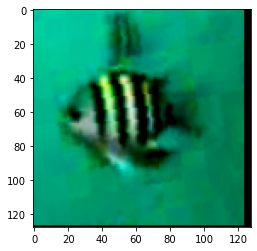

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 4,  0,  3,  0,  4,  4,  0,  4,  1, 21,  4, 12,  2,  0,  0,  0, 12,  6,
         1,  2,  0,  3,  0, 15,  6, 11,  0,  0,  0,  0,  0,  4,  0,  0,  0,  3,
         4,  0,  4,  6,  6,  0,  0,  3,  0,  1,  2,  3,  3,  8,  4,  6,  2,  4,
         0,  0,  3,  0,  0,  2,  3, 12,  1,  0])


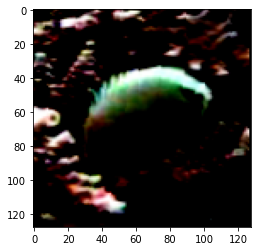

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0,  3,  6,  0, 13,  4,  4,  6,  0,  0,  0,  0,  0,  4,  0,  1, 11,  0,
         6,  9,  1,  0,  4,  3,  7,  2, 11,  5, 21,  4,  0,  3,  1,  1,  0,  4,
         3,  0,  4,  0, 17,  0,  7,  4,  0,  1,  0,  6,  0,  4,  0,  3,  0,  4,
         6,  4,  2,  0,  4,  5,  8, 18,  3,  6])


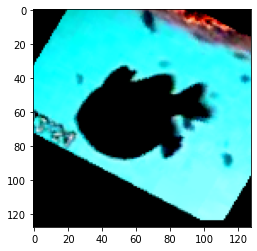

In [87]:
# 查看图片
to_pil_image = transforms.ToPILImage()
cnt = 0
for image,label in trainloader:
    if cnt>=3: # 只显示3张图片
        break
    print(label) # 显示label
 
    img = image[0] # plt.imshow()只能接受3-D Tensor，所以也要用image[0]消去batch那一维
    img = img.numpy() # FloatTensor转为ndarray
    img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
 
    # 显示图片
    plt.imshow(img)
    plt.show()
#     plt.imsave('D:/1.jpg', img)
    cnt += 1

In [88]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=23):   # num_classes，此处为 二分类值为2
        super(MobileNet, self).__init__()
        
        net = models.mobilenet_v2(pretrained=True)   # 从预训练模型加载VGG16网络参数
#         net = torch.load(r'D:\Python_first\学习内容\pytorch\wildfish\model/mobileNet freeze.pth')
        
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(1280, 512),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [33]:
net = MobileNet().to(device)

In [89]:
net = torch.load(r'D:\Python_first\learn\pytorch\wildfish\model\mobileNet_1.pth')

In [90]:
train_datasets.class_to_idx

{'fish_01': 0,
 'fish_02': 1,
 'fish_03': 2,
 'fish_04': 3,
 'fish_05': 4,
 'fish_06': 5,
 'fish_07': 6,
 'fish_08': 7,
 'fish_09': 8,
 'fish_10': 9,
 'fish_11': 10,
 'fish_12': 11,
 'fish_13': 12,
 'fish_14': 13,
 'fish_15': 14,
 'fish_16': 15,
 'fish_17': 16,
 'fish_18': 17,
 'fish_19': 18,
 'fish_20': 19,
 'fish_21': 20,
 'fish_22': 21,
 'fish_23': 22}

In [91]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
criterion.to(device=device)

CrossEntropyLoss()

In [92]:
from collections.abc import Iterable
def set_freeze_by_names(model, layer_names, freeze=True):
    if not isinstance(layer_names, Iterable):
        layer_names = [layer_names]
    for name, child in model.named_children():
        if name not in layer_names:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze

def freeze_by_names(model, layer_names):
    set_freeze_by_names(model, layer_names, True)

def unfreeze_by_names(model, layer_names):
    set_freeze_by_names(model, layer_names, False)

In [93]:
# 冻结 fc1, fc3层
freeze_by_names(net, ('features'))

In [96]:
# 解冻em, fc1, fc3层
unfreeze_by_names(net, ('features'))

In [97]:
y_predict = []
y_true = []

In [98]:
# 训练
print("Start Training!")  # 定义遍历数据集的次数
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # 准备数据
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每训练1个batch打印一次loss和准确率
        sum_loss += loss.item()
        # 每训练1个batch打印一次loss和准确率
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))

    # 每训练完一个epoch测试一下准确率
    print("Waiting Test!")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            # 取得分最高的那个类 (outputs.data的索引号)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            y_predict.append(predicted)
            y_true.append(labels)
        print('测试分类准确率为：%.3f%%' % (100 * correct / total))
        acc = 100. * correct / total
print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training!

Epoch: 1
[epoch:1, iter:1] Loss: 1.392 | Acc: 81.250% 
[epoch:1, iter:2] Loss: 1.339 | Acc: 82.812% 
[epoch:1, iter:3] Loss: 1.216 | Acc: 83.333% 
[epoch:1, iter:4] Loss: 1.208 | Acc: 82.031% 
[epoch:1, iter:5] Loss: 1.175 | Acc: 81.875% 
[epoch:1, iter:6] Loss: 1.122 | Acc: 82.292% 
[epoch:1, iter:7] Loss: 1.088 | Acc: 83.259% 
[epoch:1, iter:8] Loss: 1.136 | Acc: 82.812% 
[epoch:1, iter:9] Loss: 1.092 | Acc: 83.507% 
[epoch:1, iter:10] Loss: 1.084 | Acc: 83.594% 
[epoch:1, iter:11] Loss: 1.139 | Acc: 82.955% 
[epoch:1, iter:12] Loss: 1.140 | Acc: 82.812% 
[epoch:1, iter:13] Loss: 1.145 | Acc: 82.452% 
[epoch:1, iter:14] Loss: 1.122 | Acc: 82.589% 
[epoch:1, iter:15] Loss: 1.119 | Acc: 82.604% 
[epoch:1, iter:16] Loss: 1.136 | Acc: 82.031% 
[epoch:1, iter:17] Loss: 1.113 | Acc: 82.445% 
[epoch:1, iter:18] Loss: 1.117 | Acc: 82.292% 
[epoch:1, iter:19] Loss: 1.127 | Acc: 82.072% 
[epoch:1, iter:20] Loss: 1.128 | Acc: 82.188% 
[epoch:1, iter:21] Loss: 1.136 | Acc: 82.06

[epoch:1, iter:174] Loss: 0.759 | Acc: 88.165% 
[epoch:1, iter:175] Loss: 0.759 | Acc: 88.179% 
[epoch:1, iter:176] Loss: 0.757 | Acc: 88.192% 
[epoch:1, iter:177] Loss: 0.756 | Acc: 88.215% 
[epoch:1, iter:178] Loss: 0.754 | Acc: 88.246% 
[epoch:1, iter:179] Loss: 0.754 | Acc: 88.251% 
[epoch:1, iter:180] Loss: 0.752 | Acc: 88.279% 
Waiting Test!
测试分类准确率为：88.000%

Epoch: 2
[epoch:2, iter:181] Loss: 0.805 | Acc: 87.500% 
[epoch:2, iter:182] Loss: 0.708 | Acc: 87.500% 
[epoch:2, iter:183] Loss: 0.668 | Acc: 88.542% 
[epoch:2, iter:184] Loss: 0.698 | Acc: 89.844% 
[epoch:2, iter:185] Loss: 0.653 | Acc: 90.625% 
[epoch:2, iter:186] Loss: 0.691 | Acc: 89.583% 
[epoch:2, iter:187] Loss: 0.686 | Acc: 89.509% 
[epoch:2, iter:188] Loss: 0.665 | Acc: 89.844% 
[epoch:2, iter:189] Loss: 0.627 | Acc: 90.625% 
[epoch:2, iter:190] Loss: 0.617 | Acc: 90.625% 
[epoch:2, iter:191] Loss: 0.616 | Acc: 90.767% 
[epoch:2, iter:192] Loss: 0.594 | Acc: 91.016% 
[epoch:2, iter:193] Loss: 0.577 | Acc: 91.226% 

[epoch:2, iter:344] Loss: 0.479 | Acc: 92.797% 
[epoch:2, iter:345] Loss: 0.479 | Acc: 92.803% 
[epoch:2, iter:346] Loss: 0.479 | Acc: 92.809% 
[epoch:2, iter:347] Loss: 0.479 | Acc: 92.805% 
[epoch:2, iter:348] Loss: 0.478 | Acc: 92.811% 
[epoch:2, iter:349] Loss: 0.479 | Acc: 92.788% 
[epoch:2, iter:350] Loss: 0.477 | Acc: 92.822% 
[epoch:2, iter:351] Loss: 0.478 | Acc: 92.827% 
[epoch:2, iter:352] Loss: 0.477 | Acc: 92.842% 
[epoch:2, iter:353] Loss: 0.478 | Acc: 92.847% 
[epoch:2, iter:354] Loss: 0.477 | Acc: 92.852% 
[epoch:2, iter:355] Loss: 0.476 | Acc: 92.866% 
[epoch:2, iter:356] Loss: 0.477 | Acc: 92.871% 
[epoch:2, iter:357] Loss: 0.479 | Acc: 92.858% 
[epoch:2, iter:358] Loss: 0.478 | Acc: 92.863% 
[epoch:2, iter:359] Loss: 0.479 | Acc: 92.851% 
[epoch:2, iter:360] Loss: 0.479 | Acc: 92.856% 
Waiting Test!
测试分类准确率为：90.000%

Epoch: 3
[epoch:3, iter:361] Loss: 0.616 | Acc: 90.625% 
[epoch:3, iter:362] Loss: 0.481 | Acc: 92.969% 
[epoch:3, iter:363] Loss: 0.472 | Acc: 93.229% 

[epoch:3, iter:514] Loss: 0.393 | Acc: 93.811% 
[epoch:3, iter:515] Loss: 0.392 | Acc: 93.831% 
[epoch:3, iter:516] Loss: 0.391 | Acc: 93.820% 
[epoch:3, iter:517] Loss: 0.390 | Acc: 93.820% 
[epoch:3, iter:518] Loss: 0.391 | Acc: 93.790% 
[epoch:3, iter:519] Loss: 0.389 | Acc: 93.819% 
[epoch:3, iter:520] Loss: 0.389 | Acc: 93.838% 
[epoch:3, iter:521] Loss: 0.389 | Acc: 93.828% 
[epoch:3, iter:522] Loss: 0.389 | Acc: 93.827% 
[epoch:3, iter:523] Loss: 0.388 | Acc: 93.846% 
[epoch:3, iter:524] Loss: 0.391 | Acc: 93.836% 
[epoch:3, iter:525] Loss: 0.389 | Acc: 93.854% 
[epoch:3, iter:526] Loss: 0.390 | Acc: 93.835% 
[epoch:3, iter:527] Loss: 0.390 | Acc: 93.834% 
[epoch:3, iter:528] Loss: 0.390 | Acc: 93.843% 
[epoch:3, iter:529] Loss: 0.390 | Acc: 93.842% 
[epoch:3, iter:530] Loss: 0.389 | Acc: 93.860% 
[epoch:3, iter:531] Loss: 0.389 | Acc: 93.860% 
[epoch:3, iter:532] Loss: 0.389 | Acc: 93.868% 
[epoch:3, iter:533] Loss: 0.388 | Acc: 93.895% 
[epoch:3, iter:534] Loss: 0.388 | Acc: 9

[epoch:4, iter:684] Loss: 0.343 | Acc: 94.672% 
[epoch:4, iter:685] Loss: 0.342 | Acc: 94.688% 
[epoch:4, iter:686] Loss: 0.343 | Acc: 94.692% 
[epoch:4, iter:687] Loss: 0.342 | Acc: 94.717% 
[epoch:4, iter:688] Loss: 0.343 | Acc: 94.679% 
[epoch:4, iter:689] Loss: 0.342 | Acc: 94.694% 
[epoch:4, iter:690] Loss: 0.342 | Acc: 94.708% 
[epoch:4, iter:691] Loss: 0.342 | Acc: 94.723% 
[epoch:4, iter:692] Loss: 0.342 | Acc: 94.747% 
[epoch:4, iter:693] Loss: 0.343 | Acc: 94.730% 
[epoch:4, iter:694] Loss: 0.342 | Acc: 94.744% 
[epoch:4, iter:695] Loss: 0.342 | Acc: 94.758% 
[epoch:4, iter:696] Loss: 0.343 | Acc: 94.762% 
[epoch:4, iter:697] Loss: 0.342 | Acc: 94.775% 
[epoch:4, iter:698] Loss: 0.342 | Acc: 94.778% 
[epoch:4, iter:699] Loss: 0.342 | Acc: 94.792% 
[epoch:4, iter:700] Loss: 0.343 | Acc: 94.736% 
[epoch:4, iter:701] Loss: 0.342 | Acc: 94.759% 
[epoch:4, iter:702] Loss: 0.343 | Acc: 94.734% 
[epoch:4, iter:703] Loss: 0.344 | Acc: 94.709% 
[epoch:4, iter:704] Loss: 0.343 | Acc: 9

[epoch:5, iter:854] Loss: 0.297 | Acc: 95.522% 
[epoch:5, iter:855] Loss: 0.296 | Acc: 95.544% 
[epoch:5, iter:856] Loss: 0.295 | Acc: 95.554% 
[epoch:5, iter:857] Loss: 0.294 | Acc: 95.563% 
[epoch:5, iter:858] Loss: 0.295 | Acc: 95.539% 
[epoch:5, iter:859] Loss: 0.294 | Acc: 95.549% 
[epoch:5, iter:860] Loss: 0.293 | Acc: 95.558% 
[epoch:5, iter:861] Loss: 0.293 | Acc: 95.567% 
[epoch:5, iter:862] Loss: 0.292 | Acc: 95.588% 
[epoch:5, iter:863] Loss: 0.293 | Acc: 95.553% 
[epoch:5, iter:864] Loss: 0.293 | Acc: 95.551% 
[epoch:5, iter:865] Loss: 0.294 | Acc: 95.539% 
[epoch:5, iter:866] Loss: 0.296 | Acc: 95.505% 
[epoch:5, iter:867] Loss: 0.295 | Acc: 95.514% 
[epoch:5, iter:868] Loss: 0.294 | Acc: 95.524% 
[epoch:5, iter:869] Loss: 0.293 | Acc: 95.543% 
[epoch:5, iter:870] Loss: 0.294 | Acc: 95.521% 
[epoch:5, iter:871] Loss: 0.293 | Acc: 95.519% 
[epoch:5, iter:872] Loss: 0.293 | Acc: 95.508% 
[epoch:5, iter:873] Loss: 0.292 | Acc: 95.527% 
[epoch:5, iter:874] Loss: 0.294 | Acc: 9

[epoch:6, iter:1024] Loss: 0.263 | Acc: 95.779% 
[epoch:6, iter:1025] Loss: 0.261 | Acc: 95.812% 
[epoch:6, iter:1026] Loss: 0.261 | Acc: 95.809% 
[epoch:6, iter:1027] Loss: 0.263 | Acc: 95.768% 
[epoch:6, iter:1028] Loss: 0.264 | Acc: 95.776% 
[epoch:6, iter:1029] Loss: 0.265 | Acc: 95.773% 
[epoch:6, iter:1030] Loss: 0.264 | Acc: 95.781% 
[epoch:6, iter:1031] Loss: 0.265 | Acc: 95.766% 
[epoch:6, iter:1032] Loss: 0.267 | Acc: 95.739% 
[epoch:6, iter:1033] Loss: 0.269 | Acc: 95.724% 
[epoch:6, iter:1034] Loss: 0.269 | Acc: 95.732% 
[epoch:6, iter:1035] Loss: 0.268 | Acc: 95.741% 
[epoch:6, iter:1036] Loss: 0.270 | Acc: 95.715% 
[epoch:6, iter:1037] Loss: 0.271 | Acc: 95.712% 
[epoch:6, iter:1038] Loss: 0.270 | Acc: 95.720% 
[epoch:6, iter:1039] Loss: 0.270 | Acc: 95.717% 
[epoch:6, iter:1040] Loss: 0.268 | Acc: 95.737% 
[epoch:6, iter:1041] Loss: 0.267 | Acc: 95.756% 
[epoch:6, iter:1042] Loss: 0.269 | Acc: 95.731% 
[epoch:6, iter:1043] Loss: 0.269 | Acc: 95.717% 
[epoch:6, iter:1044]

[epoch:7, iter:1191] Loss: 0.265 | Acc: 95.749% 
[epoch:7, iter:1192] Loss: 0.266 | Acc: 95.731% 
[epoch:7, iter:1193] Loss: 0.264 | Acc: 95.741% 
[epoch:7, iter:1194] Loss: 0.262 | Acc: 95.765% 
[epoch:7, iter:1195] Loss: 0.262 | Acc: 95.761% 
[epoch:7, iter:1196] Loss: 0.262 | Acc: 95.757% 
[epoch:7, iter:1197] Loss: 0.263 | Acc: 95.726% 
[epoch:7, iter:1198] Loss: 0.262 | Acc: 95.723% 
[epoch:7, iter:1199] Loss: 0.261 | Acc: 95.733% 
[epoch:7, iter:1200] Loss: 0.261 | Acc: 95.729% 
[epoch:7, iter:1201] Loss: 0.261 | Acc: 95.726% 
[epoch:7, iter:1202] Loss: 0.260 | Acc: 95.761% 
[epoch:7, iter:1203] Loss: 0.259 | Acc: 95.770% 
[epoch:7, iter:1204] Loss: 0.259 | Acc: 95.791% 
[epoch:7, iter:1205] Loss: 0.259 | Acc: 95.762% 
[epoch:7, iter:1206] Loss: 0.258 | Acc: 95.771% 
[epoch:7, iter:1207] Loss: 0.258 | Acc: 95.792% 
[epoch:7, iter:1208] Loss: 0.257 | Acc: 95.813% 
[epoch:7, iter:1209] Loss: 0.256 | Acc: 95.833% 
[epoch:7, iter:1210] Loss: 0.256 | Acc: 95.841% 
[epoch:7, iter:1211]

[epoch:8, iter:1358] Loss: 0.222 | Acc: 96.604% 
[epoch:8, iter:1359] Loss: 0.223 | Acc: 96.575% 
[epoch:8, iter:1360] Loss: 0.222 | Acc: 96.609% 
[epoch:8, iter:1361] Loss: 0.224 | Acc: 96.597% 
[epoch:8, iter:1362] Loss: 0.224 | Acc: 96.599% 
[epoch:8, iter:1363] Loss: 0.224 | Acc: 96.587% 
[epoch:8, iter:1364] Loss: 0.226 | Acc: 96.559% 
[epoch:8, iter:1365] Loss: 0.225 | Acc: 96.577% 
[epoch:8, iter:1366] Loss: 0.225 | Acc: 96.580% 
[epoch:8, iter:1367] Loss: 0.224 | Acc: 96.598% 
[epoch:8, iter:1368] Loss: 0.223 | Acc: 96.629% 
[epoch:8, iter:1369] Loss: 0.224 | Acc: 96.603% 
[epoch:8, iter:1370] Loss: 0.223 | Acc: 96.605% 
[epoch:8, iter:1371] Loss: 0.222 | Acc: 96.608% 
[epoch:8, iter:1372] Loss: 0.222 | Acc: 96.610% 
[epoch:8, iter:1373] Loss: 0.224 | Acc: 96.571% 
[epoch:8, iter:1374] Loss: 0.225 | Acc: 96.560% 
[epoch:8, iter:1375] Loss: 0.224 | Acc: 96.562% 
[epoch:8, iter:1376] Loss: 0.222 | Acc: 96.592% 
[epoch:8, iter:1377] Loss: 0.224 | Acc: 96.568% 
[epoch:8, iter:1378]

[epoch:9, iter:1525] Loss: 0.225 | Acc: 96.342% 
[epoch:9, iter:1526] Loss: 0.225 | Acc: 96.330% 
[epoch:9, iter:1527] Loss: 0.223 | Acc: 96.354% 
[epoch:9, iter:1528] Loss: 0.221 | Acc: 96.396% 
[epoch:9, iter:1529] Loss: 0.220 | Acc: 96.419% 
[epoch:9, iter:1530] Loss: 0.219 | Acc: 96.424% 
[epoch:9, iter:1531] Loss: 0.217 | Acc: 96.463% 
[epoch:9, iter:1532] Loss: 0.216 | Acc: 96.484% 
[epoch:9, iter:1533] Loss: 0.216 | Acc: 96.472% 
[epoch:9, iter:1534] Loss: 0.214 | Acc: 96.509% 
[epoch:9, iter:1535] Loss: 0.216 | Acc: 96.464% 
[epoch:9, iter:1536] Loss: 0.217 | Acc: 96.452% 
[epoch:9, iter:1537] Loss: 0.217 | Acc: 96.456% 
[epoch:9, iter:1538] Loss: 0.216 | Acc: 96.460% 
[epoch:9, iter:1539] Loss: 0.216 | Acc: 96.449% 
[epoch:9, iter:1540] Loss: 0.219 | Acc: 96.406% 
[epoch:9, iter:1541] Loss: 0.219 | Acc: 96.426% 
[epoch:9, iter:1542] Loss: 0.221 | Acc: 96.385% 
[epoch:9, iter:1543] Loss: 0.220 | Acc: 96.390% 
[epoch:9, iter:1544] Loss: 0.224 | Acc: 96.364% 
[epoch:9, iter:1545]

[epoch:10, iter:1690] Loss: 0.204 | Acc: 96.897% 
[epoch:10, iter:1691] Loss: 0.202 | Acc: 96.919% 
[epoch:10, iter:1692] Loss: 0.201 | Acc: 96.940% 
[epoch:10, iter:1693] Loss: 0.201 | Acc: 96.961% 
[epoch:10, iter:1694] Loss: 0.200 | Acc: 96.938% 
[epoch:10, iter:1695] Loss: 0.201 | Acc: 96.917% 
[epoch:10, iter:1696] Loss: 0.209 | Acc: 96.834% 
[epoch:10, iter:1697] Loss: 0.207 | Acc: 96.875% 
[epoch:10, iter:1698] Loss: 0.210 | Acc: 96.835% 
[epoch:10, iter:1699] Loss: 0.212 | Acc: 96.835% 
[epoch:10, iter:1700] Loss: 0.209 | Acc: 96.875% 
[epoch:10, iter:1701] Loss: 0.210 | Acc: 96.856% 
[epoch:10, iter:1702] Loss: 0.208 | Acc: 96.875% 
[epoch:10, iter:1703] Loss: 0.208 | Acc: 96.875% 
[epoch:10, iter:1704] Loss: 0.206 | Acc: 96.912% 
[epoch:10, iter:1705] Loss: 0.206 | Acc: 96.893% 
[epoch:10, iter:1706] Loss: 0.208 | Acc: 96.875% 
[epoch:10, iter:1707] Loss: 0.208 | Acc: 96.893% 
[epoch:10, iter:1708] Loss: 0.210 | Acc: 96.839% 
[epoch:10, iter:1709] Loss: 0.211 | Acc: 96.822% 


In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [100]:
pre = []
tru = []
for i in y_true[-100:]:
    tru.extend(i.data.cpu().numpy())
for i in y_predict[-100:]:
    pre.extend(i.data.cpu().numpy())

In [101]:
f1 = f1_score( tru, pre, average='macro' )
p = precision_score(tru, pre, average='macro')
r = recall_score(tru, pre, average='macro')
a = accuracy_score(tru, pre)

In [102]:
print(f1, '|', p, '|', r, '|', a)

0.7592778463739411 | 0.7635447131568414 | 0.7766607007653397 | 0.9257563368765331


In [68]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

In [69]:
pre = []
tru = []
for i in y_true[-100:]:
    tru.extend(i.data.cpu().numpy())
for i in y_predict[-100:]:
    pre.extend(i.data.cpu().numpy())

F:\anaconda3\envs\torch36\lib\site-packages\ipykernel\__main__.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


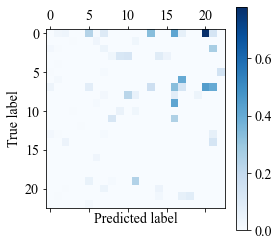

In [70]:
cfm = confusion_matrix(tru, pre)
plt.rc('font',family='Times New Roman',size='14', weight='black',)
# 矩阵变形处理：
    # 1)计算矩阵每一行的数据和；
row_sums = np.sum(cfm, axis=1)
    # 2）计算矩阵每一行的数据所站该行数据总和的比例；
err_matrix = cfm / row_sums
    # 3）让矩阵对角线的数据更改为0：因为对角线的数据全是模型预测正确的样本的数量，而分析混淆矩阵的主要目的是查看模型预测错误的地方；
        # np.fill_digonal(矩阵， m)：将矩阵对角线的数据全部改为 m；
np.fill_diagonal(err_matrix, 0)
# 图中越亮的地方就是模型犯错较多的地方，而且可以直接看出模型所犯的具体错误
plt.matshow(err_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
# plt.title('Data Augement')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./matrix/selected.jpg')
plt.show()

In [45]:
err_matrix[0, 0]

0.0

In [ ]:
err_matrix[]
plt.imshow(err_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.colorbar()
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./matrix/selected.jpg')
plt.show()

In [69]:
print(precision_score(tru, pre, average='micro'))

0.9579351535836177


In [23]:
PATH = r'./model/F4K_increase_WildFish_selected.pkl'
torch.save(net.state_dict(), PATH)

In [ ]:
net.load_state_dict(torch.load(PATH))

In [67]:
torch.save(net, './model/F4K increase WilsFish selected.pth')

F:\anaconda3\envs\torch36\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MobileNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
